In [1]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import math
import tiktoken
import torch
import torch.nn as nn

In [10]:
# Hyperparameters
batch_size = 4  # How many batches per training step
context_length = 16  # Length of the token chunk each batch
d_model = 64  # The vector size of the token embeddings
num_layers = 8  # Number of transformer blocks
num_heads = 4  # Number of heads in Multi-head attention # 我们的代码中通过 d_model / num_heads = 来获取 head_size
learning_rate = 1e-3  # 0.001
dropout = 0.1 # Dropout rate
max_iters = 500  # Total of training iterations
eval_interval = 50  # How often to evaluate the model 
eval_iters = 20  # How many iterations to average the loss over when evaluating the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Instead of using the cpu, we'll use the GPU if it's available.

TORCH_SEED = 1337
torch.manual_seed(TORCH_SEED)

In [8]:
# download a sample txt file from https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt
if not os.path.exists('data/sales_textbook.txt'):
    url = 'https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt'
    with open('sales_textbook.txt', 'w') as f:
        f.write(requests.get(url).text)

with open('data/sales_textbook.txt', 'r', encoding='utf-8') as f:
    text = f.read()
print(text[0:100])

Chapter 1: Building Rapport and Capturing Attention
Subpoint: Understanding the Importance of Buildi


### tokenizer 分词

In [11]:
# Using TikToken to tokenize the source text
encoding = tiktoken.get_encoding("cl100k_base")
tokenized_text = encoding.encode(text)
tokenized_text = torch.tensor(tokenized_text, dtype=torch.long, device=device) # Convert tokens into a tensor
max_token_value = tokenized_text.max().item() # the maximum index value in our vocabulary

print(f"Tokenized text size: {len(tokenized_text)}")
print(f"The maximum value in the tokenized text is: {max_token_value}")

Tokenized text size: 77919
The maximum value in the tokenized text is: 100069


In [12]:
# Split train and validation
split_idx = int(len(tokenized_text) * 0.9)
train_data = tokenized_text[:split_idx]
val_data = tokenized_text[split_idx:]

In [26]:
# Prepare data for training batch
data = train_data
idxs = torch.randint(low=0, high=len(data) - context_length, size=(batch_size,))
print(idxs)
x_batch = torch.stack([data[idx:idx + context_length] for idx in idxs])
y_batch = torch.stack([data[idx + 1:idx + context_length + 1] for idx in idxs])
print(x_batch.shape, x_batch.shape)
print(x_batch.data)

#[encoding.decode([i]) for i in x_batch[0]],[encoding.decode([i]) for i in y_batch[0]]

tensor([59168, 63127, 42588, 60514])
torch.Size([4, 16]) torch.Size([4, 16])
tensor([[42066,   922,   279,  2027,   477,  2532,  1694,  9076,    13, 16207,
         15749,  1288,   387,  5644,   311,  3493],
        [  810, 26662,    13,  1115,   539,  1193,  8779,   304,  8830,   279,
         54111,   719,  1101, 32216, 22785,  2802],
        [63798,  1082, 31966,   512,  4599, 32644,   279,  7720,   323, 22934,
           315,   701, 11223, 10105,    11,   433],
        [   13,  3296,  8830,   279,  6130,   596, 13356,   323, 36681,  4954,
           449,   872, 10742,    11,   499,   649]], device='cuda:0')


In [28]:
# Illustration purpose
pd.set_option('display.expand_frame_repr', False)
print("Our batches:\n", pd.DataFrame(x_batch.detach().cpu().numpy()))

Our batches:
       0      1      2     3     4      5      6     7      8      9      10    11     12     13     14    15
0  42066    922    279  2027   477   2532   1694  9076     13  16207  15749  1288    387   5644    311  3493
1    810  26662     13  1115   539   1193   8779   304   8830    279  54111   719   1101  32216  22785  2802
2  63798   1082  31966   512  4599  32644    279  7720    323  22934    315   701  11223  10105     11   433
3     13   3296   8830   279  6130    596  13356   323  36681   4954    449   872  10742     11    499   649


### Embedding 词向量嵌入

In [29]:
# Define Token Embedding look-up table
token_embedding_lookup_table = nn.Embedding(max_token_value+1, d_model).to(device) #gpt3 使用的是50257 * 12288
print("Token Embedding Look-up table: ", token_embedding_lookup_table)

Token Embedding Look-up table:  Embedding(100070, 64)


In [44]:
print(data[123], encoding.decode([data[123]]))
_ = token_embedding_lookup_table(data[61650]) # 
pd.set_option('expand_frame_repr', True)
pd.DataFrame(_.detach().cpu().numpy())
token_embedding_lookup_table.weight

tensor(374, device='cuda:0')  is


Parameter containing:
tensor([[ 0.4109, -0.2422,  0.4208,  ...,  0.6588, -1.3702, -1.6210],
        [ 0.5873,  0.2861,  0.0083,  ..., -1.1600, -1.4355, -1.5304],
        [ 0.8475,  0.0774,  0.5433,  ..., -0.1301,  1.2139, -0.9550],
        ...,
        [ 0.2215,  1.6325,  1.1309,  ...,  0.7276,  2.2216,  1.8038],
        [ 0.5758, -0.9485, -2.5025,  ...,  0.0593, -1.8601,  1.0561],
        [ 0.1381,  0.9853,  1.8310,  ..., -1.6018, -0.6596, -1.1218]],
       device='cuda:0', requires_grad=True)

In [45]:
# Get x and y embedding
x_batch_embedding = token_embedding_lookup_table(x_batch.detach().to(device)) # [4, 16, 64] [batch_size, context_length, d_model]
y_batch_embedding = token_embedding_lookup_table(y_batch.detach().to(device))

x_batch_embedding.shape, y_batch_embedding.shape
pd.DataFrame(x_batch_embedding[0].detach().cpu().numpy())


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-1.504062,0.504382,-0.506211,-1.799649,0.102880,0.867908,0.094095,0.458072,-1.553687,1.050099,...,-0.892956,-1.143659,-1.973088,0.243408,0.369648,1.914078,0.374620,0.778969,0.047803,0.603914
1,0.388163,-1.126659,-1.730978,0.156467,-0.160171,0.907849,0.711242,0.665825,1.262370,0.244848,...,-1.395881,1.231356,0.608068,0.265034,-0.698017,1.185806,-0.831584,0.689302,-1.296814,1.609069
2,1.525063,0.745981,-0.547752,1.515671,0.404259,0.338968,-0.138751,-0.254189,0.591292,-0.724745,...,1.272663,0.911819,1.705117,1.450410,-0.407635,-2.700113,0.088089,-0.949351,-1.055693,-1.378453
3,0.833605,0.043172,1.727082,0.982217,-1.427780,0.188604,0.219249,0.529542,-1.142935,-2.286170,...,1.189262,-0.191704,-0.811262,-0.316590,-0.549430,-0.085256,-0.776849,0.342896,1.632294,0.080291
4,0.831487,1.838861,-0.430661,-0.508977,-2.037453,-0.584855,-0.240290,1.381905,-0.558548,1.340093,...,0.506645,0.743362,0.048831,-1.284778,-0.998213,-1.757279,-0.559726,0.714420,-0.462698,-1.406350
5,2.365308,-0.191056,-0.077756,0.085608,-0.038059,-0.037869,-0.454850,1.263550,1.993280,-0.985197,...,0.052113,2.362511,-2.205322,-0.355131,1.505619,-0.709692,-0.510474,-2.374483,0.069222,-0.698800
6,-1.182447,-0.678267,-0.569403,0.373961,-0.989337,2.359406,-1.489648,-0.122315,1.186192,1.632254,...,1.741481,0.931108,-0.612918,-0.298914,0.660732,-1.248290,-0.009583,-0.779832,-1.359698,-1.236765
7,1.014631,-0.356527,-0.203402,-0.595957,-1.001494,-0.649205,-1.412615,-0.174468,0.305401,-1.236863,...,0.093084,-0.819667,-0.855240,-0.503600,1.565931,0.840289,0.329468,-0.118015,-1.288907,-0.180568
8,-1.428061,-1.727851,0.071533,-0.735549,0.029674,1.221902,-0.347778,1.372599,0.714992,-1.357311,...,0.405150,0.546930,0.515158,0.609129,0.122176,0.947156,0.680250,-0.455354,-0.320015,-0.179693
9,0.222714,0.224615,-1.733778,-0.287982,-0.747673,0.903909,3.212867,1.908911,1.184575,-0.505392,...,1.046278,-0.461660,-1.126432,-0.745241,0.289075,-0.951259,-0.846917,0.593094,1.494172,0.062710


### 位置编码 Position Encoding PE

In [84]:
# Define Position Encoding look-up table
context_length = 16
position_encoding_lookup_table = torch.zeros(context_length, d_model)
position = torch.arange(0, context_length, dtype=torch.float).unsqueeze(1)
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000) / d_model))
#div_term_ = 1/(10000 ** (torch.arange(0, d_model, 2).float()/d_model))
position_encoding_lookup_table[:, 0::2] = torch.sin(position * div_term)
position_encoding_lookup_table[:, 1::2] = torch.cos(position * div_term)
position_encoding_lookup_table = position_encoding_lookup_table.unsqueeze(0).expand(batch_size, -1, -1) #add batch dimension

print("Position Encoding Look-up Table: ", position_encoding_lookup_table.shape) # [4, 16, 64] [batch_size, context_length, d_model]
pd.DataFrame(position_encoding_lookup_table[0].detach().cpu().numpy())


Position Encoding Look-up Table:  torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.841471,0.540302,0.681561,0.731761,0.533168,0.846009,0.409309,0.912396,0.310984,0.950415,...,0.000422,1.000000,0.000316,1.000000,0.000237,1.000000,0.000178,1.000000,0.000133,1.000000
2,0.909297,-0.416147,0.997480,0.070948,0.902131,0.431463,0.746903,0.664932,0.591127,0.806578,...,0.000843,1.000000,0.000632,1.000000,0.000474,1.000000,0.000356,1.000000,0.000267,1.000000
3,0.141120,-0.989992,0.778273,-0.627927,0.993253,-0.115966,0.953634,0.300967,0.812649,0.582754,...,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000,0.000400,1.000000
4,-0.756802,-0.653644,0.141539,-0.989933,0.778472,-0.627680,0.993281,-0.115730,0.953581,0.301137,...,0.001687,0.999999,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000
5,-0.958924,0.283662,-0.571127,-0.820862,0.323935,-0.946079,0.858896,-0.512150,0.999947,-0.010342,...,0.002108,0.999998,0.001581,0.999999,0.001186,0.999999,0.000889,1.000000,0.000667,1.000000
6,-0.279415,0.960170,-0.977396,-0.211416,-0.230368,-0.973104,0.574026,-0.818837,0.947148,-0.320796,...,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999,0.000800,1.000000
7,0.656987,0.753902,-0.859313,0.511449,-0.713721,-0.700430,0.188581,-0.982058,0.800422,-0.599437,...,0.002952,0.999996,0.002214,0.999998,0.001660,0.999999,0.001245,0.999999,0.000933,1.000000
8,0.989358,-0.145500,-0.280228,0.959933,-0.977262,-0.212036,-0.229904,-0.973213,0.574318,-0.818632,...,0.003374,0.999994,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999
9,0.412118,-0.911130,0.449194,0.893434,-0.939824,0.341660,-0.608108,-0.793854,0.291259,-0.956644,...,0.003795,0.999993,0.002846,0.999996,0.002134,0.999998,0.001600,0.999999,0.001200,0.999999


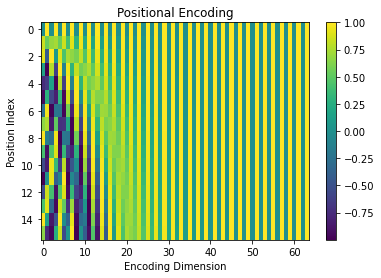

In [85]:
# Illustration Purpose Only
def visualize_pe(pe):
    plt.imshow(pe, aspect="auto")
    plt.title("Positional Encoding")
    plt.xlabel("Encoding Dimension")
    plt.ylabel("Position Index")
    plt.colorbar()
    plt.show()

position_encoding_lookup_table2_np = position_encoding_lookup_table[0].cpu().numpy()
visualize_pe(position_encoding_lookup_table2_np)

In [86]:
# Add positional encoding into the input embedding vector
input_embedding_x = x_batch_embedding + position_encoding_lookup_table.to(device) # [4, 16, 64] [batch_size, context_length, d_model]
input_embedding_y = y_batch_embedding + position_encoding_lookup_table.to(device)
pd.DataFrame(input_embedding_x[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-1.504062,1.504382,-0.506211,-0.799649,0.102880,1.867908,0.094095,1.458072,-1.553687,2.050099,...,-0.892956,-0.143659,-1.973088,1.243408,0.369648,2.914078,0.374620,1.778969,0.047803,1.603914
1,1.229634,-0.586357,-1.049416,0.888228,0.372998,1.753858,1.120551,1.578221,1.573353,1.195263,...,-1.395459,2.231356,0.608384,1.265034,-0.697779,2.185806,-0.831406,1.689302,-1.296681,2.609069
2,2.434361,0.329834,0.449728,1.586619,1.306390,0.770430,0.608152,0.410744,1.182419,0.081834,...,1.273507,1.911818,1.705750,2.450410,-0.407161,-1.700113,0.088445,0.050649,-1.055426,-0.378453
3,0.974725,-0.946820,2.505354,0.354291,-0.434527,0.072638,1.172884,0.830509,-0.330286,-1.703416,...,1.190527,0.808295,-0.810313,0.683409,-0.548718,0.914744,-0.776315,1.342896,1.632694,1.080291
4,0.074684,1.185218,-0.289122,-1.498910,-1.258981,-1.212535,0.752990,1.266175,0.395032,1.641230,...,0.508332,1.743360,0.050096,-0.284779,-0.997264,-0.757279,-0.559015,1.714419,-0.462164,-0.406350
5,1.406383,0.092606,-0.648883,-0.735253,0.285877,-0.983948,0.404046,0.751400,2.993227,-0.995539,...,0.054222,3.362509,-2.203741,0.644868,1.506804,0.290308,-0.509585,-1.374483,0.069888,0.301200
6,-1.461862,0.281904,-1.546799,0.162544,-1.219704,1.386303,-0.915622,-0.941152,2.133340,1.311458,...,1.744011,1.931105,-0.611020,0.701084,0.662155,-0.248291,-0.008516,0.220167,-1.358898,-0.236766
7,1.671618,0.397375,-1.062716,-0.084507,-1.715215,-1.349634,-1.224034,-1.156526,1.105822,-1.836301,...,0.096036,0.180329,-0.853027,0.496398,1.567591,1.840288,0.330712,0.881984,-1.287974,0.819431
8,-0.438702,-1.873351,-0.208695,0.224385,-0.947588,1.009865,-0.577682,0.399386,1.289310,-2.175943,...,0.408523,1.546924,0.517688,1.609125,0.124073,1.947155,0.681673,0.544645,-0.318949,0.820307
9,0.634833,-0.686515,-1.284585,0.605453,-1.687497,1.245569,2.604759,1.115057,1.475834,-1.462036,...,1.050074,0.538333,-1.123586,0.254754,0.291209,0.048739,-0.845317,1.593093,1.495372,1.062709


### 多头注意力

In [88]:
# Prepare Query, Key, Value for Multi-head Attention
X = input_embedding_x
query = key = value = X # [4, 16, 64] [batch_size, context_length, d_model]
query.shape

torch.Size([4, 16, 64])

In [89]:
# Define Query, Key, Value weight matrices #GPT3 在这个地方是12228*12228*3 
Wq = nn.Linear(d_model, d_model).to(device)
Wk = nn.Linear(d_model, d_model).to(device)
Wv = nn.Linear(d_model, d_model).to(device)

Q = Wq(query).to(device) #[4, 16, 64]
Q = Q.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

K = Wk(key).to(device) #[4, 16, 64]
K = K.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

V = Wv(value).to(device)#[4, 16, 64]
V = V.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

# print(torch.round(Q[0] * 100) / 100)
qqq = Q.detach().cpu().numpy()
pd.set_option('expand_frame_repr', False)
for qs in qqq:
    for qss in qs:
        print(pd.DataFrame(qss))

print(Q.shape) # [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]

         0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0 -0.483035 -0.144645  0.345868 -0.103917 -0.284563  0.659995 -0.527768  0.008083 -0.071787 -0.188218 -1.680553 -0.977897  0.524723  0.665524  1.329464  1.505745
1 -0.125465  0.622822  1.064484 -0.983860 -1.631503 -0.894079 -0.177813 -0.508005  0.208044 -0.589639 -0.304111  1.209237  1.638136  1.043831  1.609459 -0.380458
2 -1.911567 -1.927676 -0.559515 -0.339262 -0.380249 -1.674076 -0.626238  0.155199 -1.127440 -0.222830  0.068789 -0.410950  0.131461  0.268011 -0.227489  0.676344
3  0.103971  1.654519  0.338847 -0.635510  0.474307  0.727134  0.830663 -0.228101 -1.153803 -0.033151 -0.738679 -0.726786 -0.980715  0.119180  0.438383  0.028570
         0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0 -0.809021 -0.964309 -0.624

In [90]:
# Transpose q,k,v from [batch_size, context_length, num_heads, head_size] to [batch_size, num_heads, context_length, head_size]
# The reason is that treat each batch with "num_heads" as its first dimension.
Q = Q.transpose(1, 2) # [4, 4, 16, 16]
K = K.transpose(1, 2) # [4, 4, 16, 16]
V = V.transpose(1, 2) # [4, 4, 16, 16]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.901036,1.227282,0.600713,-0.178986,0.493400,-0.682915,-0.380771,0.620559,-0.075999,0.419925,0.107943,0.117759,0.407793,0.187792,0.374945,0.099258
1,-0.196929,-0.372561,-1.268905,-0.725670,-0.943214,0.035924,0.242513,-0.064263,-0.131084,0.071470,-0.138095,0.039851,-0.566650,0.394454,0.248913,-0.702541
2,1.153273,-0.123330,-0.266794,-0.150930,-0.323347,-0.098901,0.111328,-0.026649,0.358279,0.019882,0.140017,-0.193649,0.109560,0.603190,0.286954,-0.490423
3,0.191624,0.569074,0.424272,1.004017,0.508289,0.941261,-0.132046,0.836941,0.215730,0.140741,0.288629,0.654550,-0.354519,1.013857,0.271096,0.811580
4,0.064916,0.134631,-0.739988,0.102216,-0.221088,-0.045071,0.004338,0.404576,-0.192773,0.588402,0.327895,0.253305,-0.279750,0.327837,0.265466,-0.025877
5,0.178520,-0.170857,0.372201,0.090573,0.023242,0.130283,-0.696535,-0.814833,-0.801191,-0.757467,-0.835840,-0.222611,-0.735609,0.044564,-0.381479,-0.354726
6,0.225243,-0.491852,0.328815,-0.231919,0.268235,-0.510446,0.175444,-0.621290,-0.096117,-0.537835,0.070877,-0.491389,0.576194,-0.296241,-0.807574,-0.080870
7,-0.069259,-0.071403,-0.883897,-0.972646,-0.339647,-0.936400,0.420627,0.840865,-0.095255,0.029808,0.333487,-0.162278,0.077214,0.130721,-0.101857,-0.291161
8,-0.211454,0.336864,-0.410699,-0.246618,-0.038889,0.224144,0.720569,0.786571,0.600288,0.137560,0.406368,0.053497,0.040346,0.721720,-0.034935,0.256427
9,0.161440,0.628070,0.088120,0.109915,0.071206,-0.087749,-0.394350,0.208904,-0.123643,0.146714,-0.150978,-0.012587,-0.255686,0.371675,-0.105242,0.356877


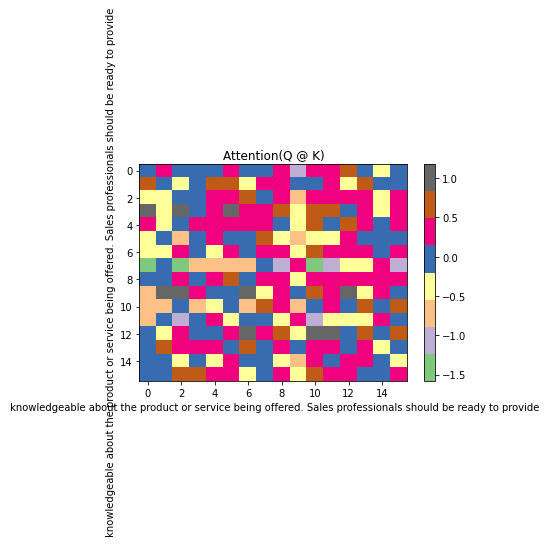

In [98]:
# Calculate the attention score
attention_score = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_model // num_heads) # [4, 4, 16, 16]

# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q @ K)") #plot attention in the first head of the first batch
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.901036,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
1,-0.196929,-0.372561,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
2,1.153273,-0.123330,-0.266794,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
3,0.191624,0.569074,0.424272,1.004017,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
4,0.064916,0.134631,-0.739988,0.102216,-0.221088,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
5,0.178520,-0.170857,0.372201,0.090573,0.023242,0.130283,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
6,0.225243,-0.491852,0.328815,-0.231919,0.268235,-0.510446,0.175444,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
7,-0.069259,-0.071403,-0.883897,-0.972646,-0.339647,-0.936400,0.420627,0.840865,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
8,-0.211454,0.336864,-0.410699,-0.246618,-0.038889,0.224144,0.720569,0.786571,0.600288,-inf,-inf,-inf,-inf,-inf,-inf,-inf
9,0.161440,0.628070,0.088120,0.109915,0.071206,-0.087749,-0.394350,0.208904,-0.123643,0.146714,-inf,-inf,-inf,-inf,-inf,-inf


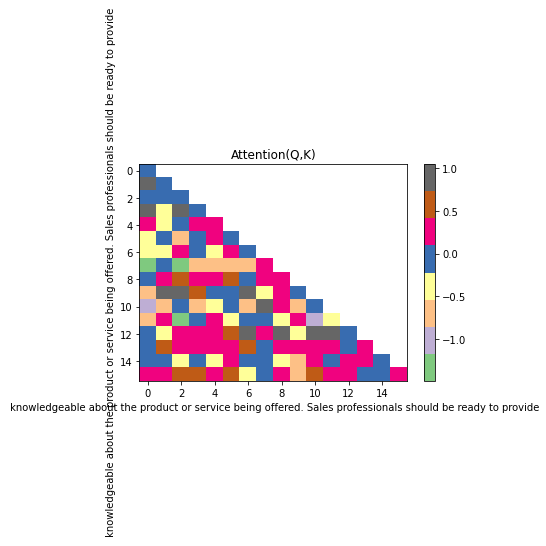

In [99]:
# Apply Mask to attention scores
attention_score = attention_score.masked_fill(torch.triu(torch.ones(attention_score.shape[-2:]).to(device), diagonal=1).bool(), float('-inf'))#[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]

# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q,K)")
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

In [100]:
# Softmax the attention score
attention_score = torch.softmax(attention_score, dim=-1) #[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.543795,0.456205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.657600,0.183460,0.158941,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.167398,0.244160,0.211246,0.377197,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.232094,0.248852,0.103776,0.240915,0.174363,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.177188,0.124940,0.215054,0.162270,0.151704,0.168844,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.175288,0.085570,0.194416,0.110971,0.182988,0.083994,0.166773,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.122762,0.122499,0.054359,0.049742,0.093678,0.051579,0.200363,0.305018,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.067779,0.117281,0.055535,0.065437,0.080546,0.104779,0.172135,0.183880,0.152627,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.104971,0.167389,0.097550,0.099700,0.095914,0.081818,0.060214,0.110074,0.078933,0.103437,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [114]:
from bertviz import head_view

att_first_head = [attention_score[i].unsqueeze(0) for i in range(batch_size)]
print(att_first_head[0].shape)

token_list = [[encoding.decode_single_token_bytes(i).decode('utf-8')] for i in x_batch[0].tolist()]
head_view(att_first_head, token_list, prettify_tokens=False)

torch.Size([1, 4, 16, 16])


<IPython.core.display.Javascript object>

In [115]:
# Calculate the V attention output
print(attention_score.shape) #[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]
print(V.shape) #[4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]
A = torch.matmul(attention_score, V) # [4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]
print(A.shape)

torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])


In [116]:
# Concatenate the attention output
A = A.transpose(1, 2) # [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]
A = A.reshape(batch_size, -1, d_model) # [4, 16, 64] [batch_size, context_length, d_model]
A.shape

torch.Size([4, 16, 64])

In [117]:
# Define the output weight matrix  
Wo = nn.Linear(d_model, d_model).to(device)
output = Wo(A) # [4, 16, 64] [batch_size, context_length, d_model]
print(output.shape)
pd.DataFrame(output[0].detach().cpu().numpy())

torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.257698,0.290396,-0.031222,0.824565,-0.334129,0.020445,0.114607,-0.519970,-0.436790,-0.240451,...,-0.192480,0.129589,0.464023,0.342569,0.698525,-0.107650,0.093669,-0.242655,0.013258,-0.172108
1,-0.427533,0.458576,-0.089455,0.498869,-0.260328,-0.060703,-0.011726,-0.643733,-0.249000,-0.348806,...,-0.186201,-0.083371,0.248550,0.457816,0.601333,-0.244966,-0.113271,-0.097857,-0.150765,-0.354057
2,-0.265037,0.442411,-0.095993,0.457221,-0.027879,-0.066367,0.171611,-0.461743,-0.231913,-0.283986,...,-0.193581,0.088270,0.233621,0.186980,0.415763,-0.219299,0.010511,-0.102717,-0.148413,-0.164188
3,-0.229711,0.472687,-0.040139,0.116126,0.038180,-0.172874,0.031185,-0.507269,-0.085847,-0.280400,...,-0.111161,0.143315,0.022059,0.185924,0.186443,-0.245187,0.036935,-0.071398,-0.083382,-0.251967
4,-0.404578,0.404411,-0.053851,0.090040,-0.033506,-0.164156,-0.129517,-0.331326,0.115238,-0.214887,...,-0.065205,-0.050647,-0.107311,-0.082470,0.188506,-0.444878,0.246009,-0.212961,0.036168,-0.120708
5,-0.220607,0.335001,-0.149424,0.058685,-0.070354,-0.179904,-0.020800,-0.307425,0.117208,-0.142991,...,0.035467,-0.133142,-0.095554,0.018547,0.123423,-0.431487,0.058735,-0.181675,0.042434,-0.195240
6,-0.145404,0.357259,-0.085251,0.044308,0.013793,-0.200105,-0.013905,-0.316798,0.058439,-0.195088,...,0.056935,-0.143509,-0.060039,0.062496,0.090296,-0.483445,0.066474,-0.132456,-0.061922,-0.202536
7,-0.195889,0.385290,-0.186053,0.223137,-0.032337,-0.220559,-0.039838,-0.302650,0.007832,-0.246621,...,-0.047912,0.051206,0.066452,0.002675,0.170911,-0.553261,0.136556,-0.170036,-0.095670,-0.096497
8,-0.171627,0.302179,-0.144294,0.090986,0.046013,-0.239726,0.011401,-0.308662,-0.009779,-0.195317,...,-0.015863,-0.058831,0.075134,0.044015,0.120044,-0.512134,0.155021,-0.089211,-0.086722,-0.097914
9,-0.130202,0.306438,-0.236553,0.031370,0.159057,-0.402940,-0.071072,-0.275595,0.116639,-0.231032,...,0.007969,-0.140611,-0.043716,0.006467,0.019632,-0.612815,0.026220,-0.121193,-0.190232,-0.102517


In [118]:
# Add residual connection
output = output + X

In [119]:
# Add Layer Normalization
layer_norm = nn.LayerNorm(d_model).to(device)
output_layernorm = layer_norm(output)

In [120]:
# Define Feed Forward Network
output = nn.Linear(d_model, d_model * 4).to(device)(output_layernorm)
output = nn.ReLU()(output)#GPT2 使用的是GELU
output = nn.Linear(d_model * 4, d_model).to(device)(output)
output = torch.dropout(output, p=dropout, train=True)

In [121]:
# Add residual connection & layerNorm (last time in a Transformer block)
output = output + output_layernorm
# Add Layer Normalization
layer_norm = nn.LayerNorm(d_model).to(device)
output = layer_norm(output)
print(output.shape)

torch.Size([4, 16, 64])


In [122]:
# Apply the final linear layer to get the logits
logits = nn.Linear(d_model, max_token_value+1).to(device)(output)
pd.DataFrame(logits[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,100060,100061,100062,100063,100064,100065,100066,100067,100068,100069
0,0.080545,0.798774,-0.043565,-0.449871,-0.296742,-0.594701,0.321268,-0.107760,-1.239502,-0.790804,...,0.597063,-0.352877,0.175247,0.527972,0.209741,0.018194,0.102186,0.896823,1.033071,-0.152419
1,-0.502055,0.561710,0.142239,0.019540,-0.785552,0.168848,1.000550,-0.502236,0.258927,-0.703864,...,0.444979,0.323552,0.480593,-0.240522,-0.216832,0.266636,0.443284,1.043074,-0.019018,0.160314
2,0.361043,0.441650,-0.008430,0.116473,0.232037,0.046840,0.018732,-0.161668,0.540041,-0.841339,...,0.486073,-1.161841,-0.241482,-0.632608,-0.569466,0.466575,-0.416128,-0.070200,-0.635855,0.743081
3,0.450594,0.613565,0.064976,-0.123004,-0.290083,0.025786,0.246508,0.438667,0.676295,-0.132734,...,0.139738,-0.460782,-0.381909,0.449279,-0.751773,0.656160,-0.590511,-0.176626,-0.222890,1.098386
4,-0.802383,0.567862,0.025494,-0.842311,-0.327030,0.116103,0.767738,0.092498,-0.029016,-0.599009,...,0.484075,0.692514,-1.535601,1.009655,-0.631642,-0.451864,-0.244022,0.405825,0.449185,0.395402
5,-0.046793,-0.504163,0.684144,-1.096191,0.287117,-0.844073,0.107996,-0.096384,0.344426,-0.006738,...,0.011349,-0.162527,-0.441051,0.510430,-0.381087,-0.179214,0.060014,0.496572,-0.459242,0.427632
6,0.490469,0.576269,0.583090,-0.928297,-0.356464,0.634941,-0.318773,-0.291867,-0.052361,0.217763,...,-0.663318,-0.135836,-0.094059,0.863346,0.422547,-0.425421,-0.247616,0.422106,-0.088268,-1.255546
7,0.238049,0.021314,0.203365,-0.102211,-0.044662,-0.436562,0.455133,0.115982,0.733148,-0.369356,...,-0.200107,0.047740,-0.256246,1.201960,0.472763,0.034265,-0.445001,-0.700842,0.679194,0.146598
8,-0.218677,0.309466,0.513117,-0.526554,0.047034,-0.696798,0.254038,-0.628378,-0.020930,-0.402957,...,-0.232485,-1.084167,-0.472503,0.050572,-0.137394,-0.476024,0.084325,-0.586379,-0.408775,0.323906
9,-0.141592,0.539347,1.007670,-0.159980,0.663780,-0.512873,1.081871,0.576443,0.464085,-0.328788,...,-0.936875,0.787512,-0.170261,0.986245,-0.189827,0.958975,0.086545,0.156376,-0.129168,-0.052317


In [123]:
# Get the probabilities 
# torch.softmax usually used during inference, during training we use torch.nn.CrossEntropyLoss
# but for illustration purpose, we'll use torch.softmax here
probabilities = torch.softmax(logits, dim=-1)
pd.DataFrame(probabilities[0].detach().cpu().numpy())
probabilities.shape

torch.Size([4, 16, 100070])

In [126]:
# Let's see the predicted token and it's original English word
predicted_index = torch.argmax(probabilities[0,0]).item()
encoding.decode([predicted_index])

' ambos'

In [129]:
# Let's see the original input sentence
print(encoding.decode(x_batch[0].tolist()))
print(encoding.decode(y_batch[0].tolist()))

 knowledgeable about the product or service being offered. Sales professionals should be ready to provide
 about the product or service being offered. Sales professionals should be ready to provide accurate


In [ ]:
# Looks like the predicted token "Catholics" is not the correct prediction token to the original sentence, because we only did one training loop and barely trained nothing.
# But this is the basic idea of how the Transformer works.
# We'll continue to train the model in the next notebook and wrap the above code into a class.
# https://waylandzhang.github.io/en/let-s-code-llm.html